In [1]:
import confmain
import os
import copy
import numpy as np
import pandas as pd

import tensorflow as tf

import pywt
import wfdb
from wfdb import processing

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from util_module import util_func
from util_module.ecg_signal import ECGSignal

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, '../data/ludb')

In [3]:
LEADS = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']

LEAD = 'ii'

In [4]:
data = ECGSignal.get_signal(leads=[LEAD])
data_df = pd.DataFrame(data=data)

data_df

,record_number,lead,signal,is_st_elevation
0,1,ii,"[0.019071310116086235, 0.07877280265339967, 0....",0
1,2,ii,"[0.050514499532273154, 0.047708138447146865, 0...",0
2,3,ii,"[-0.03641160949868074, -0.02163588390501319, -...",0
3,4,ii,"[0.4372523117569353, 0.5257595772787318, 0.486...",0
4,5,ii,"[0.09219858156028368, 0.11524822695035461, 0.1...",0
...,...,...,...,...
195,196,ii,"[-0.06503298774740811, -0.0999057492931197, -0...",0
196,197,ii,"[-0.016414141414141416, -0.02904040404040404, ...",0
197,198,ii,"[0.011210762331838564, 0.00523168908819133, 0....",0
198,199,ii,"[0.13657957244655583, 0.1377672209026128, 0.14...",0


In [5]:
data_df[data_df['is_st_elevation'] == 1]

,record_number,lead,signal,is_st_elevation
6,7,ii,"[0.4247159090909091, 0.4275568181818182, 0.431...",1
20,21,ii,"[-0.01898188093183779, -0.008628127696289905, ...",1
23,24,ii,"[-0.071875, -0.05625, -0.04609375, -0.04453125...",1
32,33,ii,"[-0.206794682422452, -0.20236336779911374, -0....",1
54,55,ii,"[-0.04893350062735257, -0.05520702634880803, -...",1
63,64,ii,"[-0.11225997045790251, -0.12703101920236337, -...",1
68,69,ii,"[-0.006983240223463687, -0.046089385474860335,...",1
85,86,ii,"[-0.2132701421800948, -0.21800947867298578, -0...",1


**ST-elevation on records [7, 21, 24, 33, 55, 64, 69, 86]**

In [6]:
def remove_zero_padding(signal, segment, thresh=50):
    if len(signal) != len(segment):
        print('Signal and segment length mismatch!')
        return

    counter = 0
    ptr_start_zero_pad = 0

    for i in reversed(range(len(signal))):
        if (signal[i] != 0) and (segment[i] != 7):
            counter += 1
            if (signal[i+1] == 0) and (segment[i+1] == 7):
                ptr_start_zero_pad = i + 1
        
        if (signal[i] == 0) and (segment[i] == 7):
            counter = 0
        
        if counter == thresh:
            break
    
    signal = signal[:ptr_start_zero_pad]
    segment = segment[:ptr_start_zero_pad]

    return signal, segment

In [7]:
INPUT_LENGTH = 816

FS = 500
T1 = 125
T2 = 245

MIN_BPM = 20
MAX_BPM = 230

SEARCH_RADIUS = int(FS * 60 / MAX_BPM)

WAVELET_FUNCTION = 'bior3.3'
DECOMPOSITION_LEVEL = 7

In [8]:
model = tf.keras.models.load_model(f'../model/{LEAD}-CustomModel.h5')

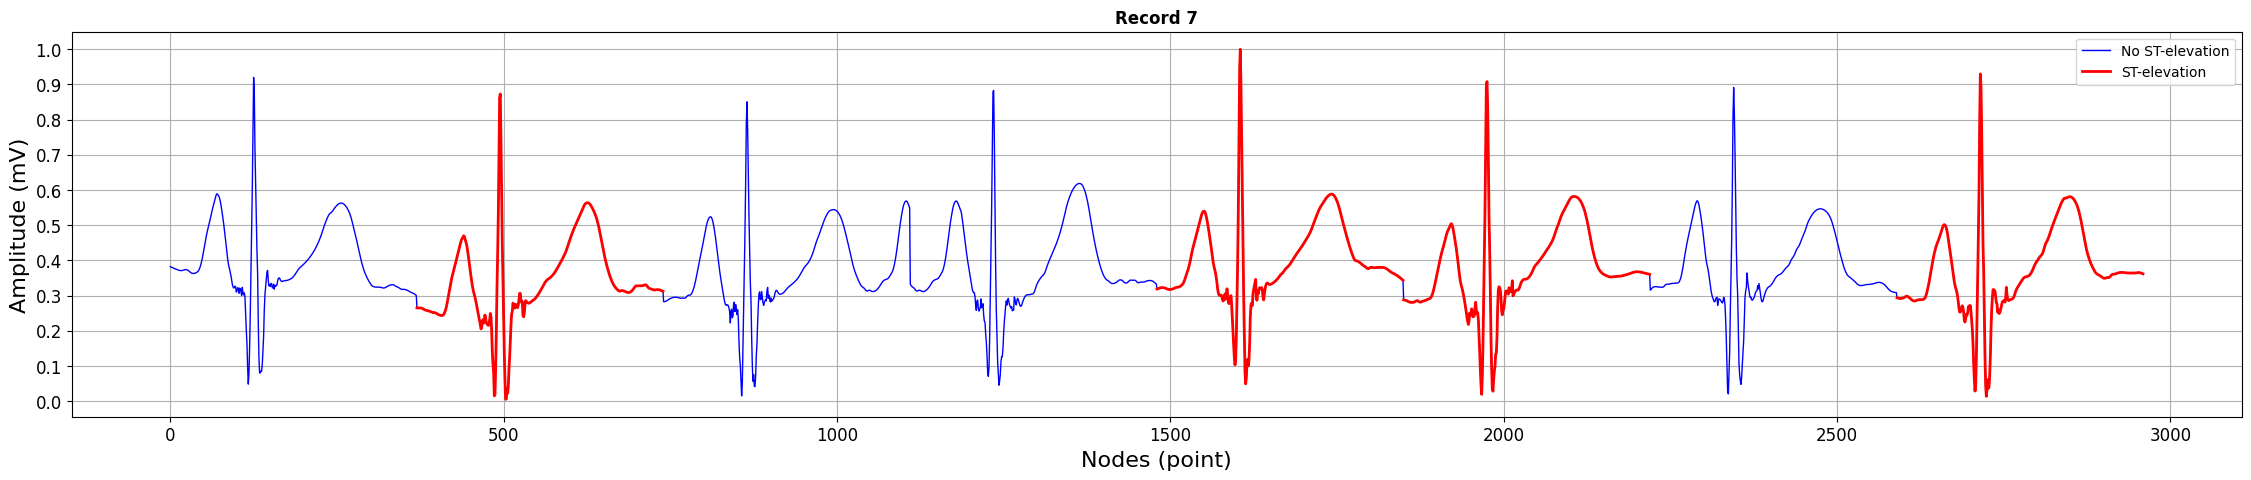

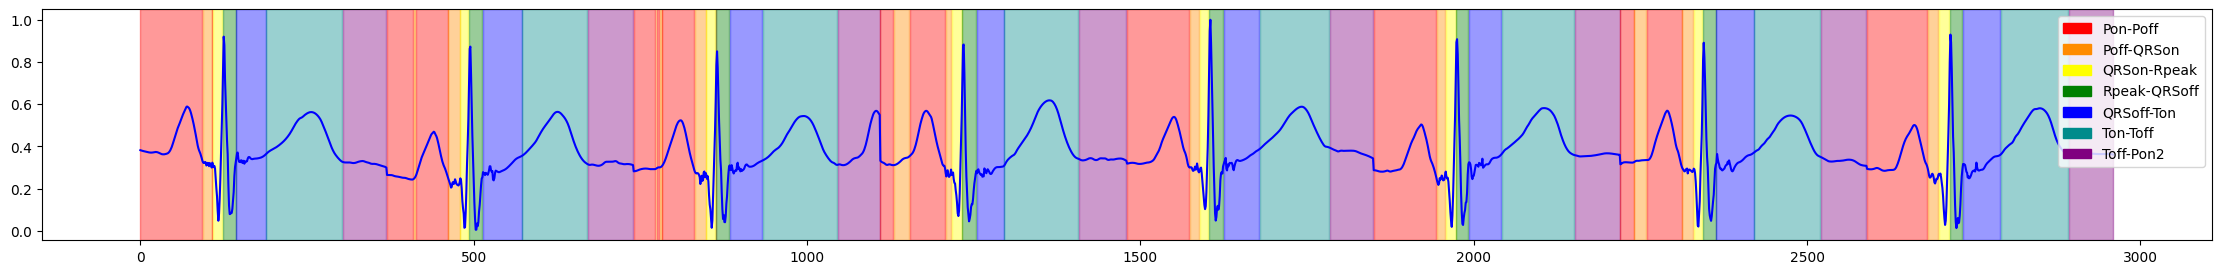

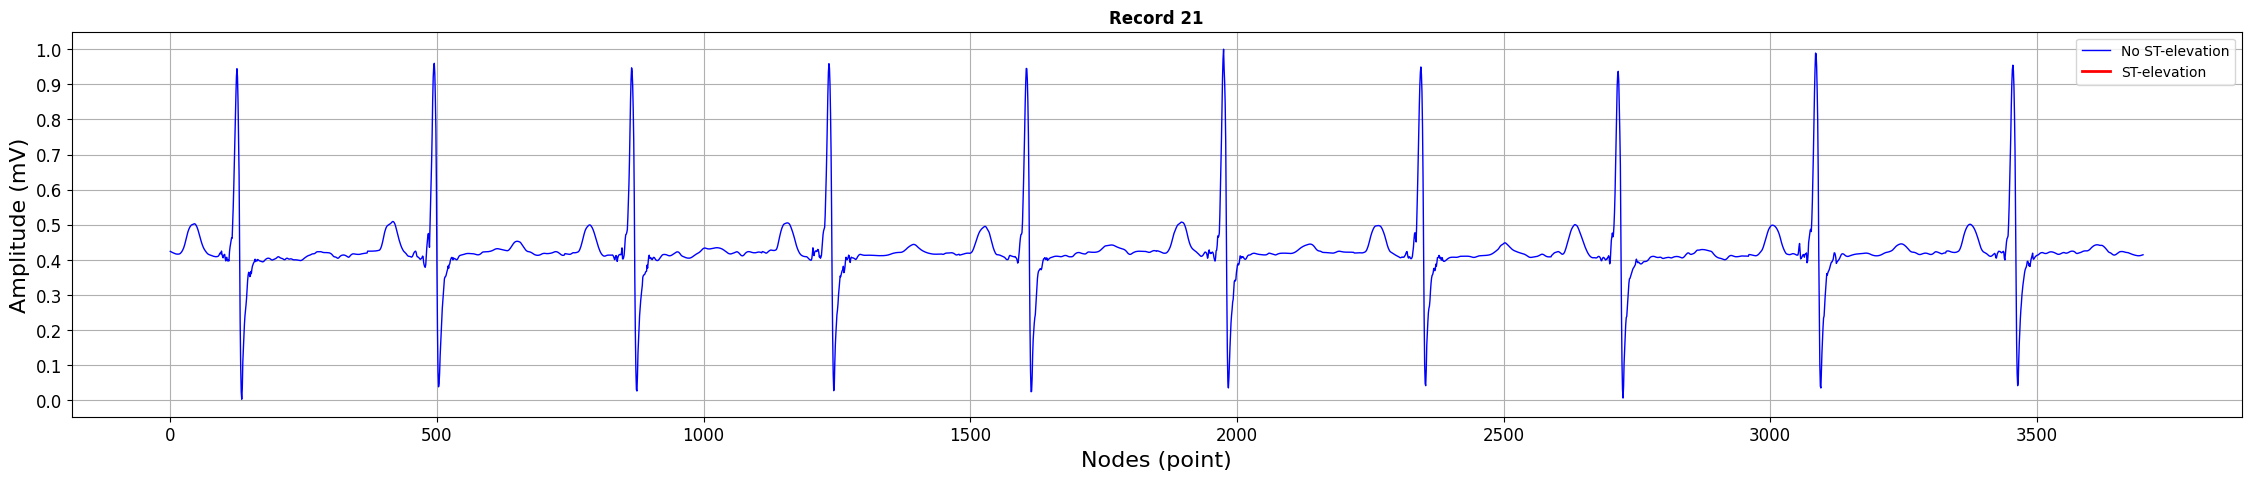

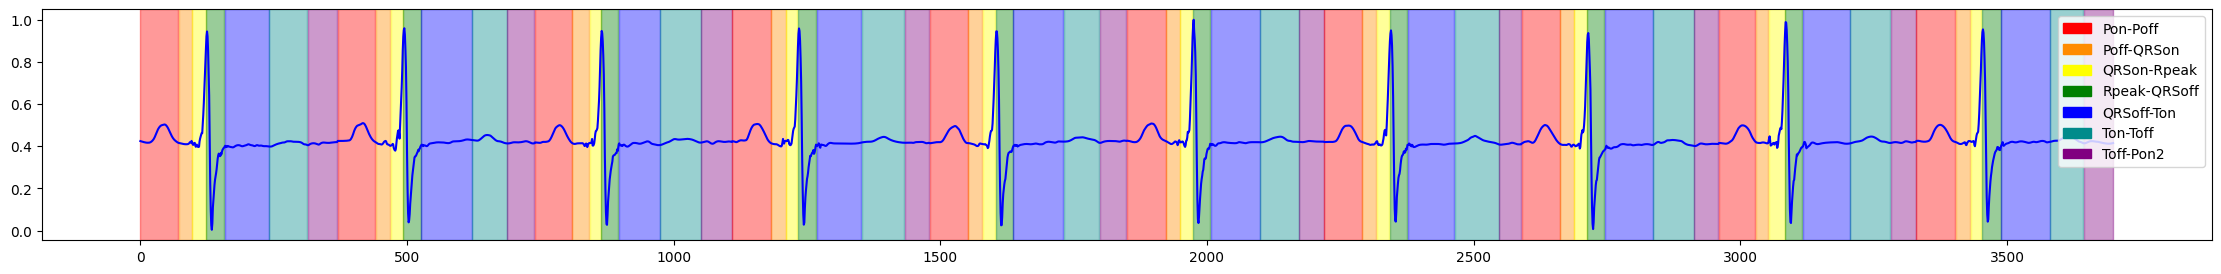

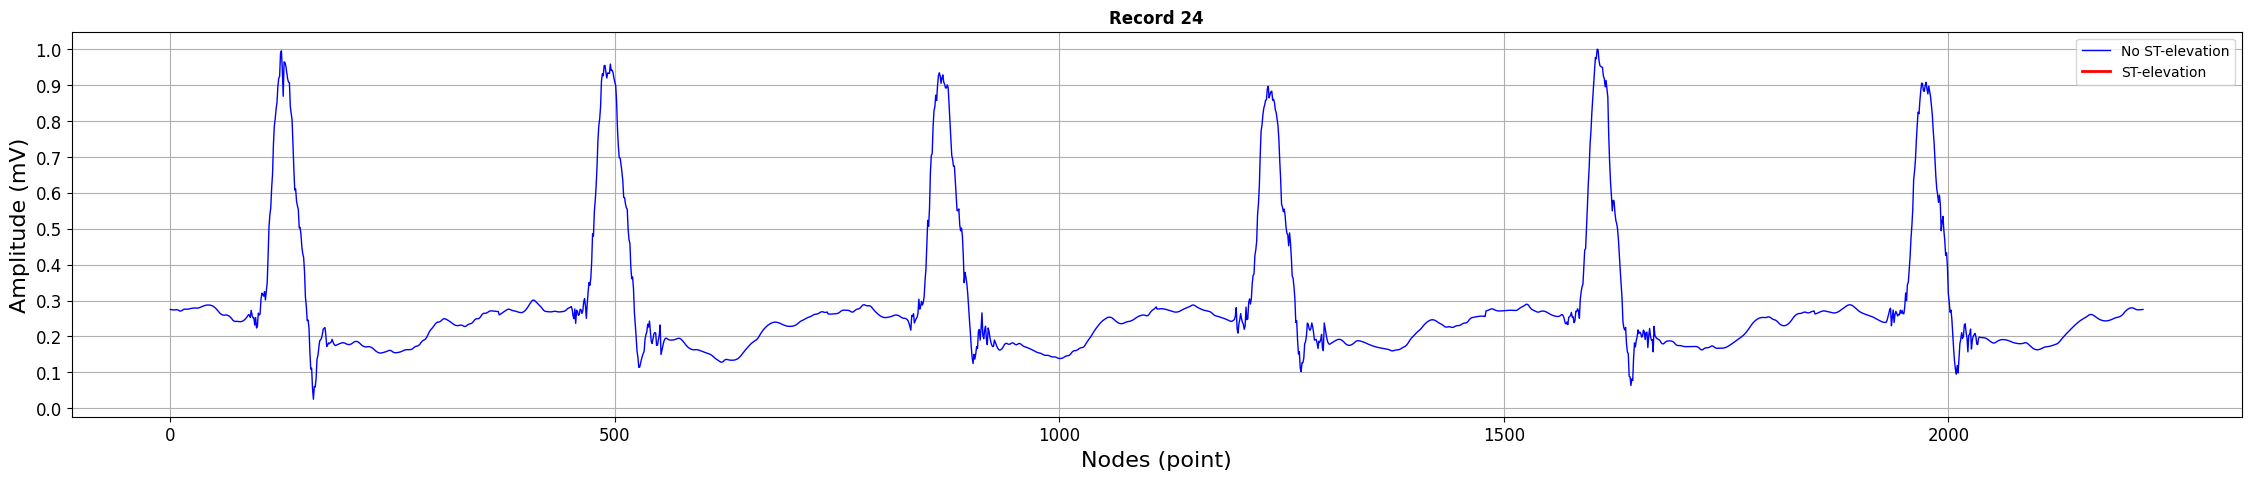

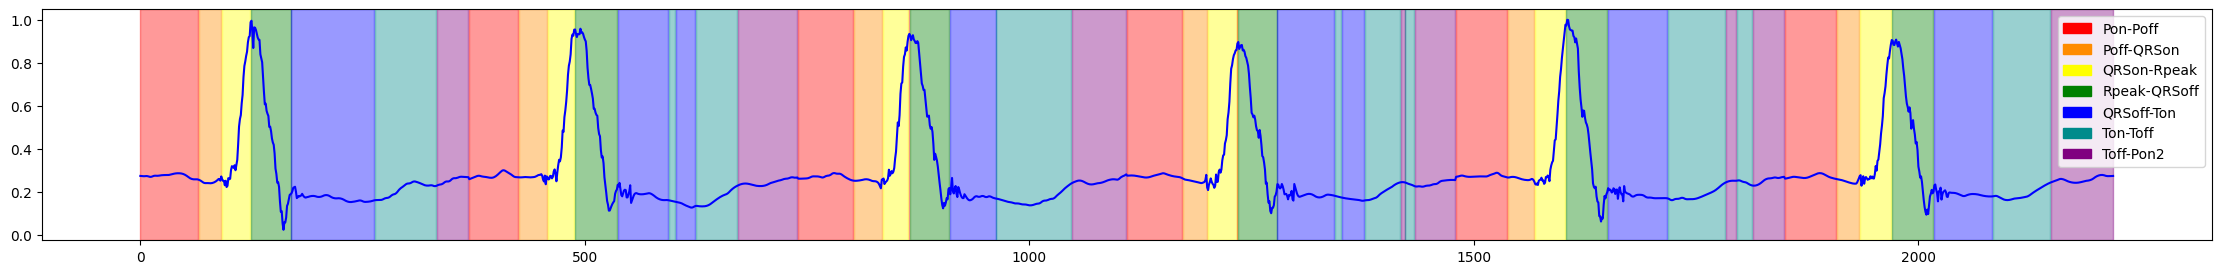

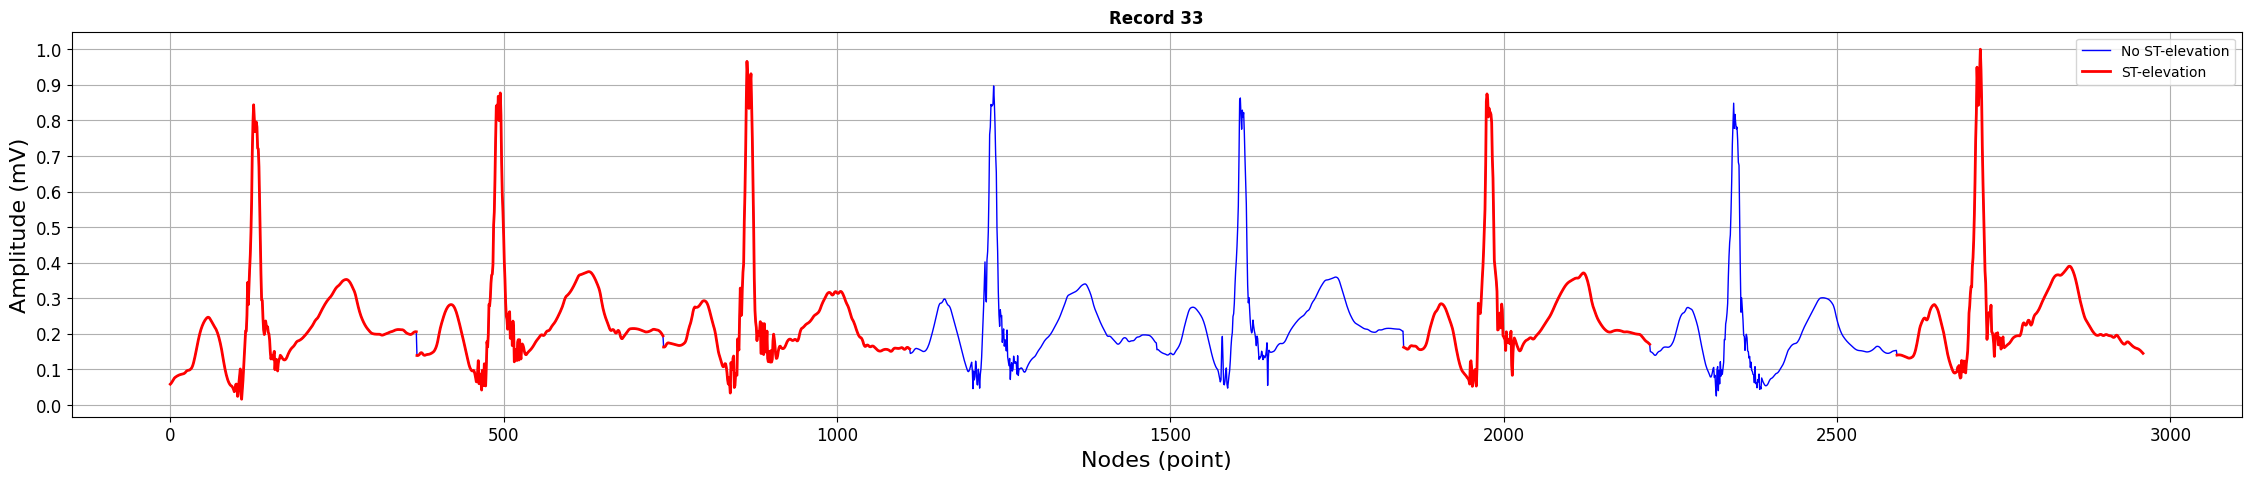

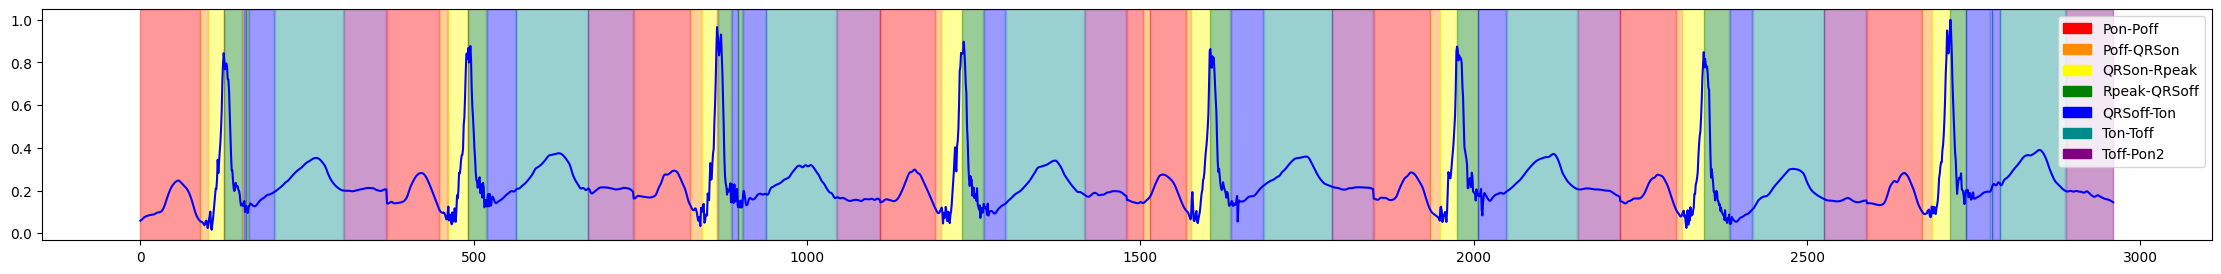

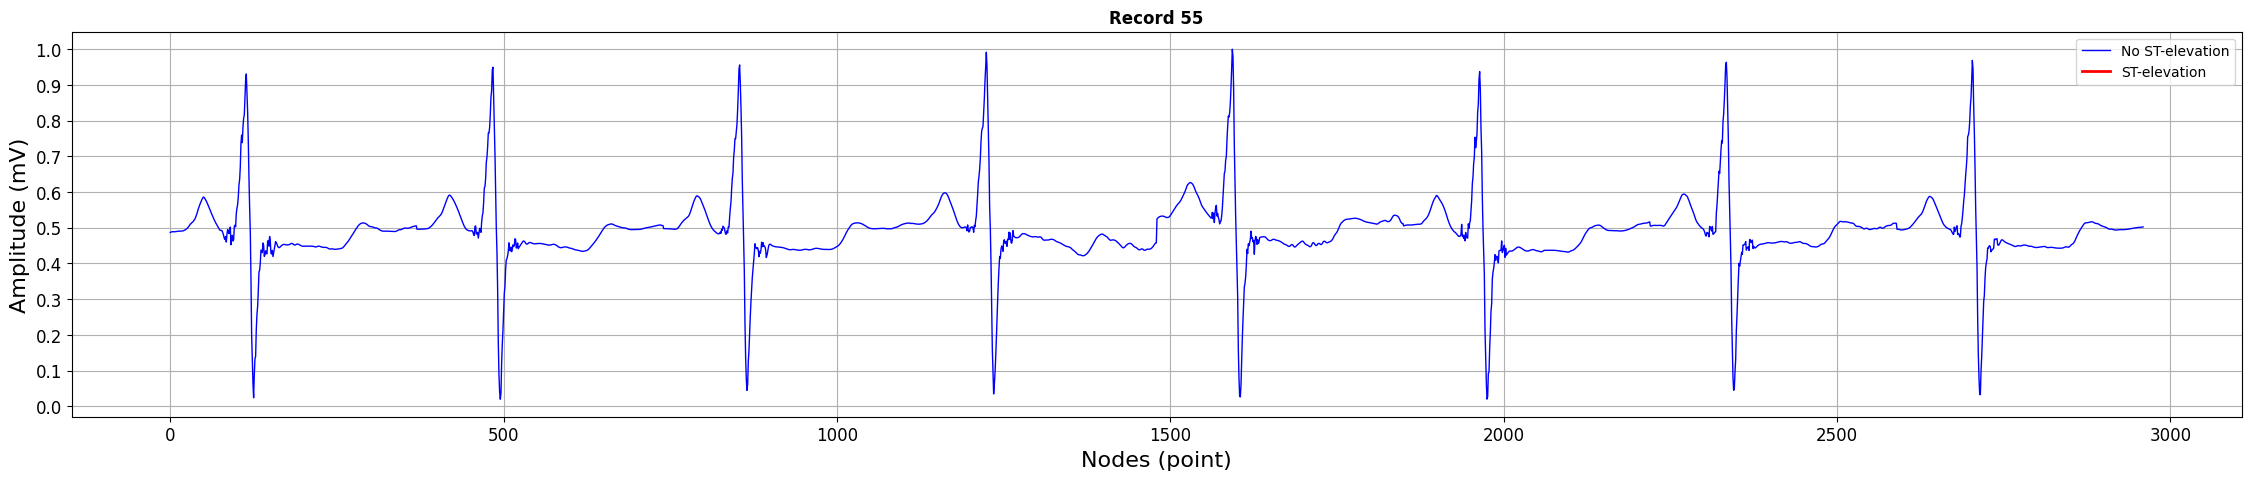

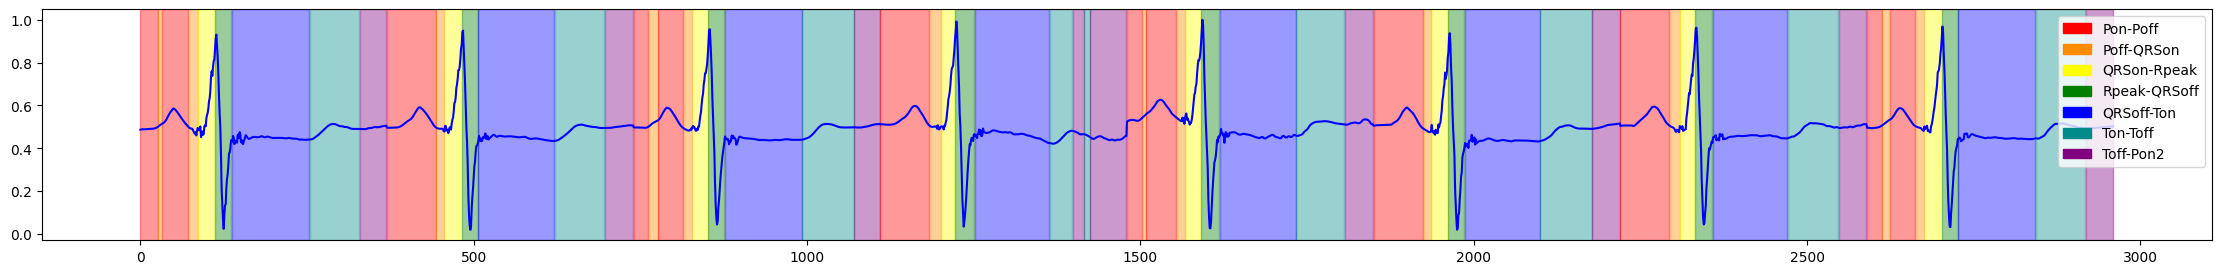

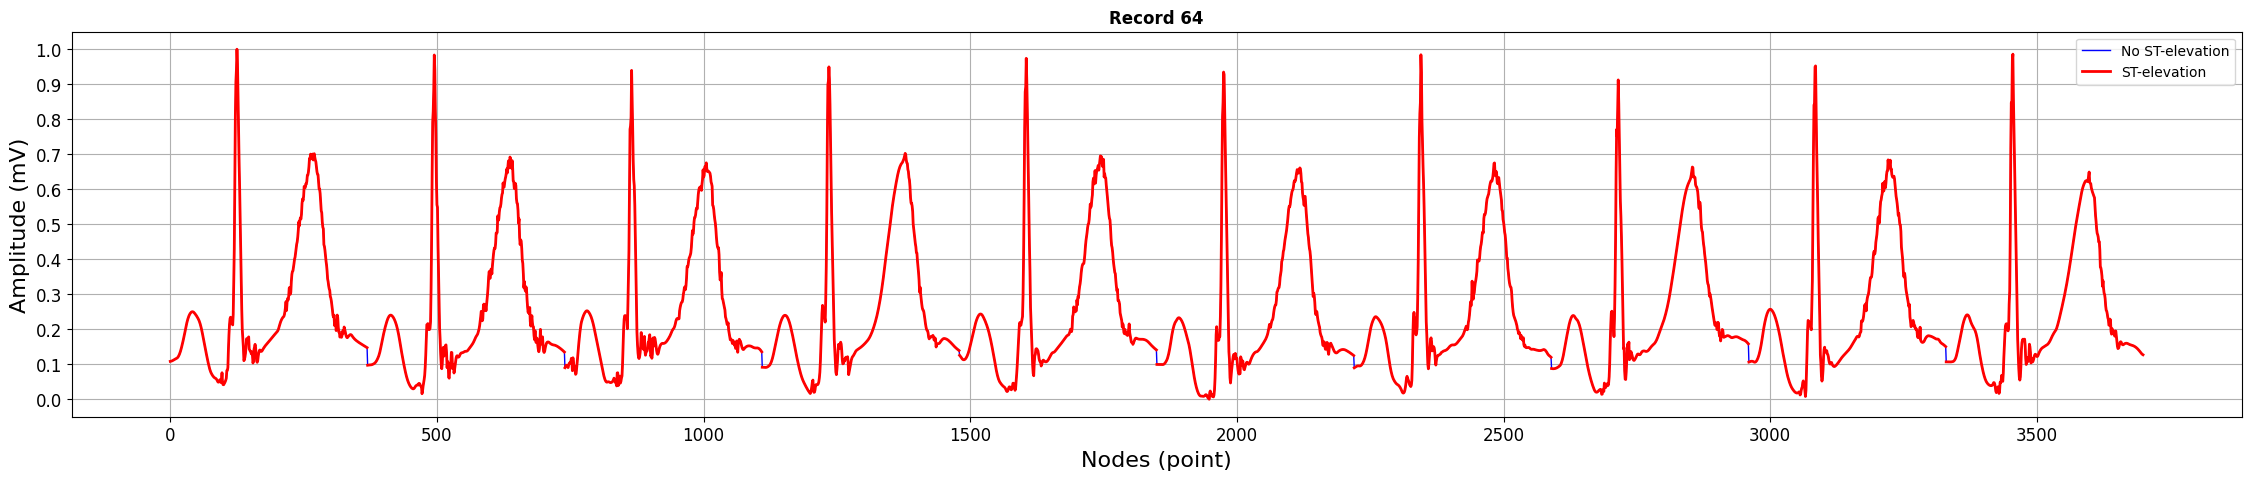

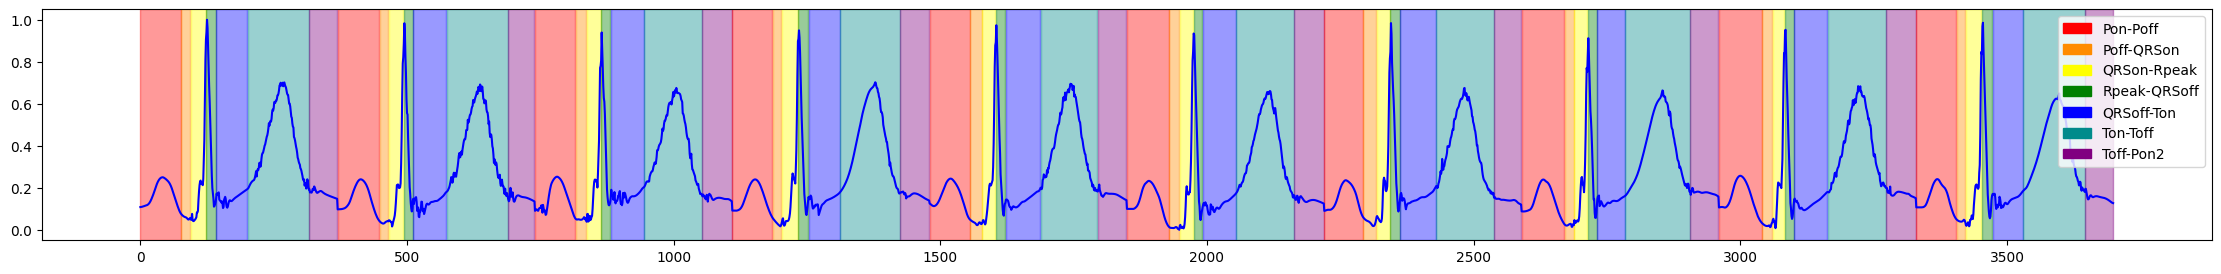

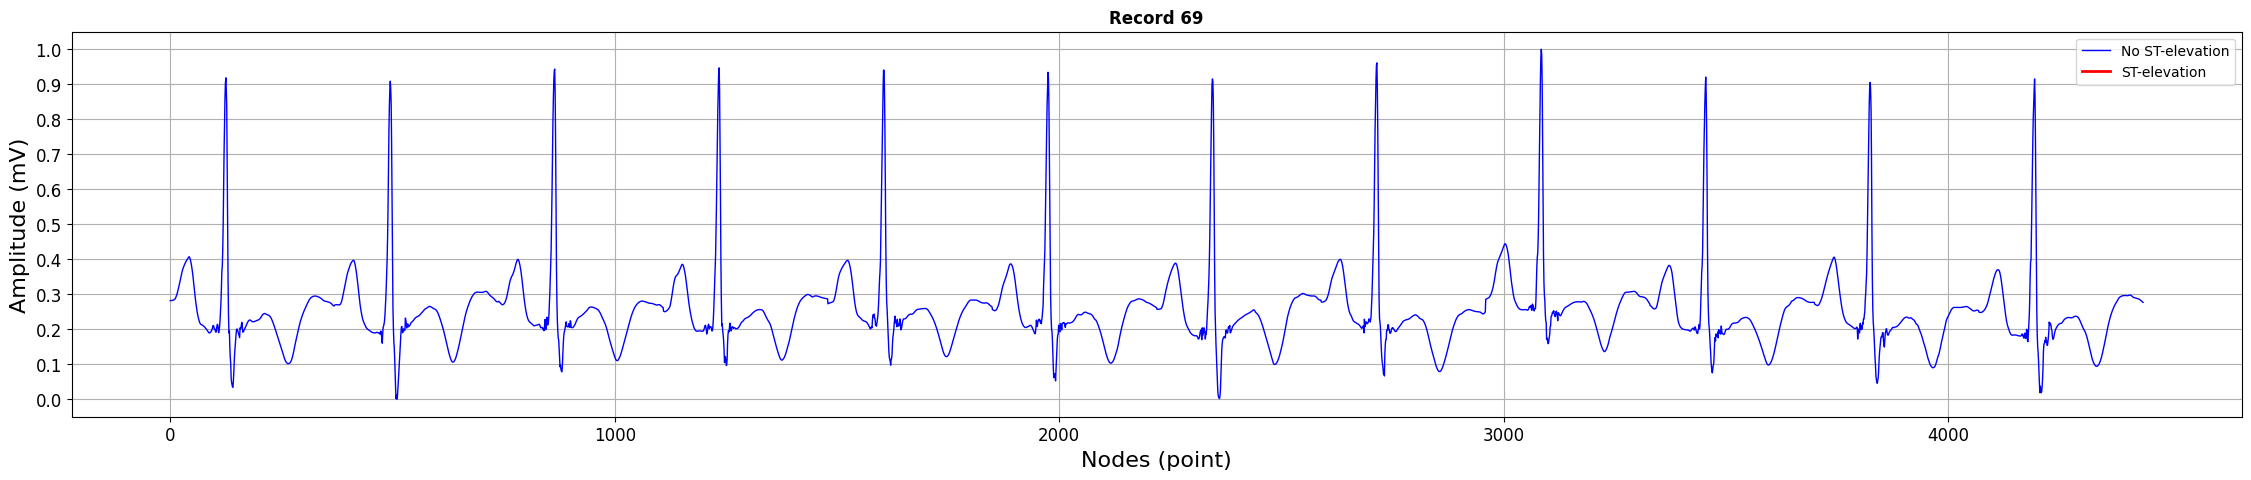

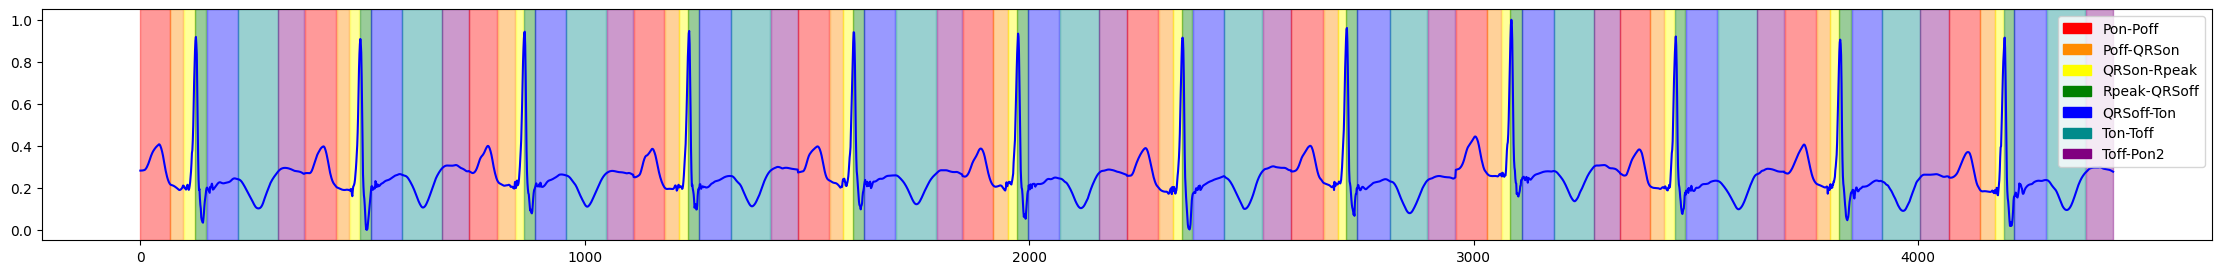

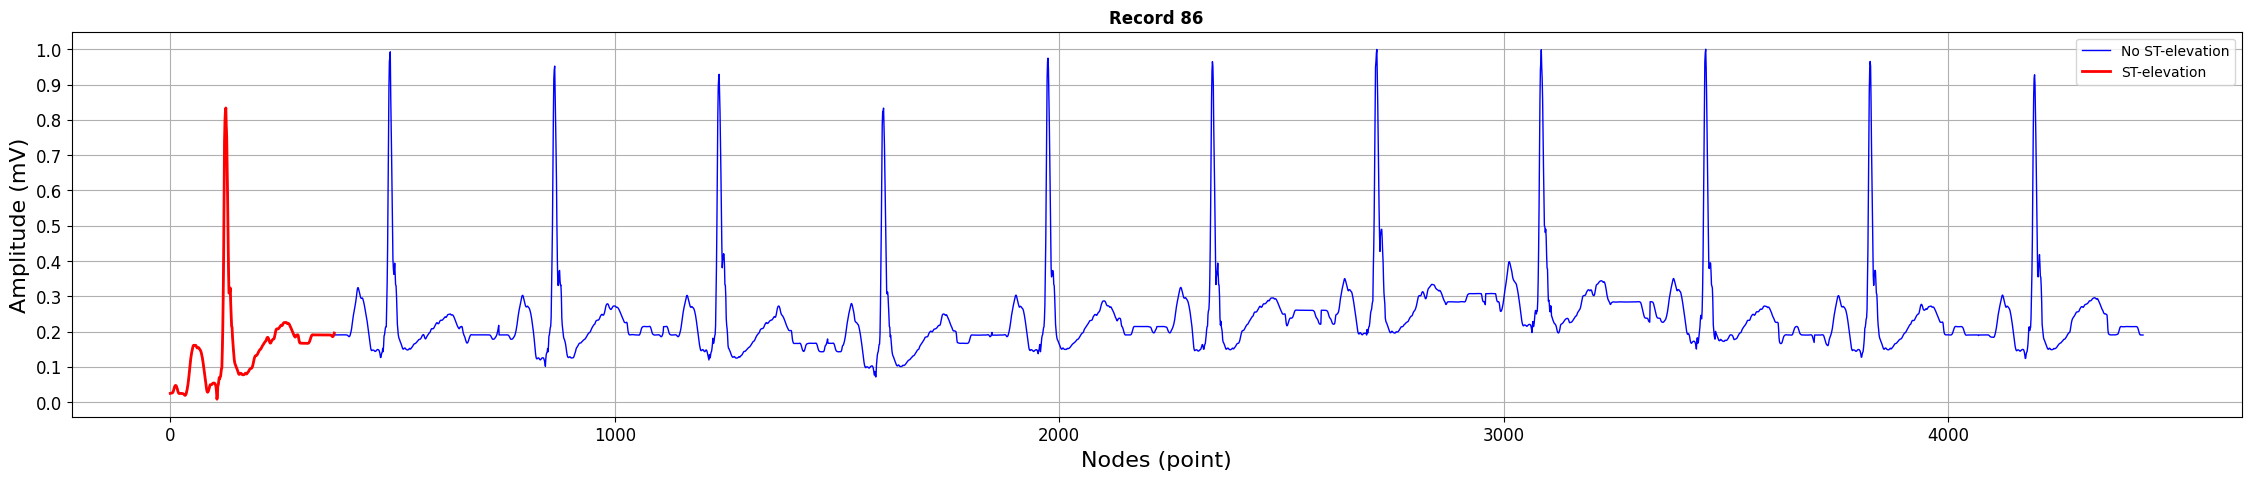

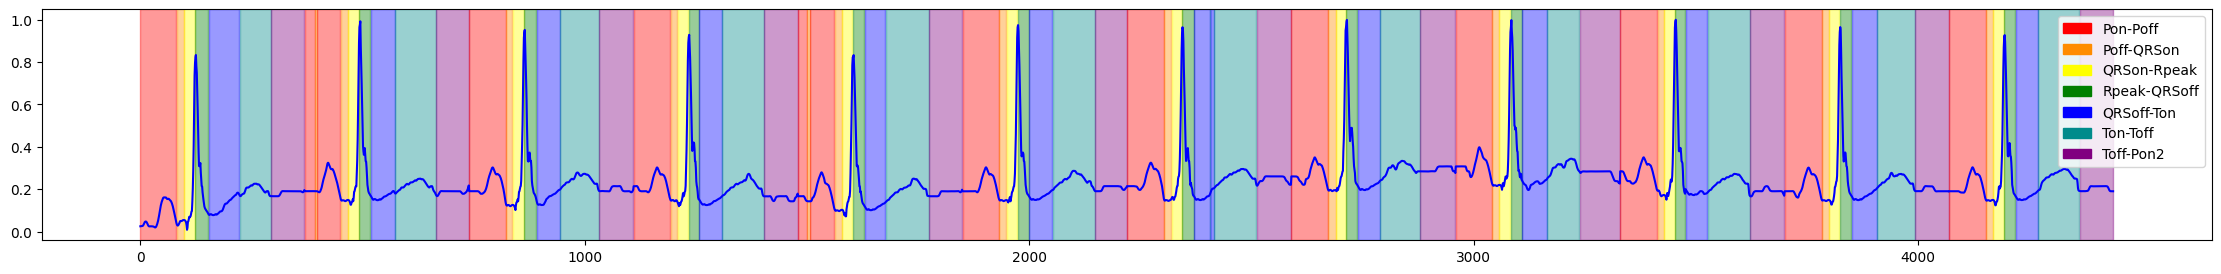

In [9]:
STEMI_RECORD = [7, 21, 24, 33, 55, 64, 69, 86]
# STEMI_RECORD = [7]

for record_num in STEMI_RECORD:
    signal = data['signal'][record_num-1]

    signal = util_func.denoise_dwt(signal, wavelet=WAVELET_FUNCTION, level=DECOMPOSITION_LEVEL)
    signal = processing.normalize_bound(signal)

    index_qrs = processing.gqrs_detect(signal, fs=FS)

    if len(index_qrs) == 0:
        print("Can't detect QRS")
        continue

    corrected_peak_inds = processing.peaks.correct_peaks(
        signal,
        peak_inds=index_qrs,
        search_radius=SEARCH_RADIUS,
        smooth_window_size=150,
    )

    if len(corrected_peak_inds) % 2 != 0:
        corrected_peak_inds = np.delete(corrected_peak_inds, -1)

    offset = 0
    beats = []
    delineations = []
    interpretations = [0]*len(corrected_peak_inds)
    st_start_end = []
    for j, peak in enumerate(corrected_peak_inds):
        if (peak - T1) < 0 or (peak + T2) > len(signal):
            continue

        beat = signal[peak - T1 : peak + T2]

        beat = np.pad(beat, (0, INPUT_LENGTH - len(beat)))
        # beats.append(beat)
        beat = beat.reshape((1, -1, 1))

        y_pred = model.predict(beat, verbose=0)
        y_pred = y_pred.round().reshape((INPUT_LENGTH, 8))
        y_pred = y_pred.argmax(axis=1)
        # delineations.append(y_pred)

        segment_start_end = util_func.get_segment_start_end(y_pred)

        beat = beat.flatten()

        beat, y_pred = remove_zero_padding(beat, y_pred)
        
        beats.extend(beat)
        delineations.extend(y_pred)


        try:
            pr_segment = segment_start_end[1][0]
            st_segment = segment_start_end[4][0]
        except:
            print(f'Record number {record_num} failed.')
            ECGSignal.plot_signal_segments(signal, y_pred)

        min_pr_idx = pr_segment[0] + beat[pr_segment[0]:pr_segment[1]+1].argmin()
        max_st_idx = st_segment[0] + beat[st_segment[0]:st_segment[1]+1].argmax()

        min_pr_amplitude = beat[min_pr_idx]
        max_st_amplitude = beat[max_st_idx]

        if max_st_amplitude - min_pr_amplitude > 0.1:
            # print(record_num, min_pr_amplitude, max_st_amplitude)
            
            # fig, ax = plt.subplots(figsize=(28, 6))
            # ECGSignal.plot_signal_segments(beat, y_pred, ax=ax)
            # ax.set_title(f'Record {record_num}')
            # ax.hlines(y=min_pr_amplitude, xmin=pr_segment[0], xmax=st_segment[1], linewidth=2, color='black')
            # ax.hlines(y=max_st_amplitude, xmin=pr_segment[0], xmax=st_segment[1], linewidth=2, color='black')
            # fig.savefig(f'../result/{record_num}')

            st_start_end.append((offset, offset + len(beat)))
        
        offset += len(beat)

    fig, ax = plt.subplots(figsize=(28, 5))

    ax.plot(beats, color='blue', linewidth=1)
    for st_start, st_end in st_start_end:
        ax.plot(range(st_start, st_end), beats[st_start:st_end], color='red', linewidth=2)

    ax.set_xlabel('Nodes (point)', fontsize=16)
    ax.set_ylabel('Amplitude (mV)', fontsize=16)

    ax.set_yticks(np.arange(0, 1 + 0.1, 0.1))
    ax.grid()
    legend_patches = [
        Line2D([0], [0], label='No ST-elevation', color='blue', linewidth=1),
        Line2D([0], [0], label='ST-elevation', color='red', linewidth=2)
    ]
    ax.legend(handles=legend_patches, loc='upper right')

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f'Record {record_num}', weight='bold')

    fig.savefig(f'../result/other/{LEAD}-{record_num}', bbox_inches='tight')

    # ECGSignal.plot_signal_segments(beats, delineations, save_path=f'../result/other/delineation-{LEAD}-{record_num}')
    

# result = copy.deepcopy(data)
# result['interpretation'] = interpretation
# result_df = pd.DataFrame(data=result)